## import libraries

In [3]:
import sys
!pip install torch torchvision torchtext pytorch_lightning tensorboard matplotlib tqdm wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 9.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 5.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 2.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 935.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 29.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [1]:
import torch
torch.cuda.is_available()
!nvidia-smi

Sun Nov 27 19:19:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   33C    P0    23W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np 
import csv
import os
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import nn



## Load data

In [3]:
import urllib.request
import os
import zipfile
if not os.path.exists(os.getcwd()+"/ipeo_data"):
    with zipfile.ZipFile(os.getcwd()+"/ipeo_data.zip", 'r') as zip_ref:
        zip_ref.extractall()


In [42]:
train_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
train_csv  = csv.reader(train_csv)
test_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
test_csv  = csv.reader(test_csv)
val_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
val_csv  = csv.reader(val_csv)
### CAREFUL need to remove the "25595_11025_label" from the validation dataset. Empty image ?
### remove direcly in the val excel fil (row = 629)

In [43]:
len(list(train_csv))

7357

## Set up the data

In [79]:
from torch.utils.data import Dataset

from PIL import Image

import os
import glob

"""CLASS rocks (1), scree (2), sparse rocks (3), water (4), glacier and permanent snow (5), forest(6), sparse forest(7),
grasslands and others (8)."""

class Alpine(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'rocks': 		  0,
      'scree': 			    1,
      'sparse_rocks': 	  2,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    5,
      'sparse_forest':   6,
      'grasslands_and_others': 				    7,
      
    }

    def __init__(self, transforms=None, split='train'):
        self.transforms = transforms
        #only for label_image
        transforms_label = T.Compose([
        T.ToTensor()
        ])
        self.transforms_label = transforms_label
        
        # prepare data
        self.data = []                                  # list of tuples of (image path, label class)
        length=0
        # get images with correct index according to dataset split
        if split=='train':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
            data_csv  = csv.reader(data_csv)
            length = 736
        if split=='test':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
            data_csv  = csv.reader(data_csv)
            length = 368
        if split=='val':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
            data_csv  = csv.reader(data_csv)
            length = 123
            
        i=0
        print(length)
        for row in data_csv :
            if i<length:
                img_name = os.getcwd()+"/ipeo_data/rgb/"+row[0]+"_rgb.tif"
                img_label_name = os.getcwd()+"/ipeo_data/alpine_label/"+row[0]+"_label.tif"   
                i+=1
        # example format: 'baseFolder/agricultural/agricultural07.tif'
                self.data.append((
                    img_name,
                    img_label_name          # get index for label class
                ))


    #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        img_name, img_label_name = self.data[x]
    
        img = Image.open(img_name)
        img_label = Image.open(img_label_name)
        
        
        if self.transforms is not None:
            img = self.transforms(img)
            img_label = self.transforms_label(img_label)
        return img,img_label


In [81]:
# initialize the dataset (call the constructor __init__)

dataset = Alpine(split= "train")
print(f"dataset of length {len(dataset)}")
# plot individual samples
from ipywidgets import interact
@interact(idx=range(100))
def plot_sample(idx=0):
    img, img_label = dataset[idx]
    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(img_label)




736
dataset of length 736


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

## Test ( Image input 400 sur 400 / label 200 sur 200 --> need to resize the input)

In [82]:
train_dataset = Alpine(transforms=transforms_train, split='train')
print(len(train_dataset))

736
736


In [ ]:
transforms_train

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(unnormalize(train_dataset[94][0]).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow((train_dataset[94][1]).permute(1,2,0))

In [ ]:
train_dataset[94][0].permute(1,2,0).shape,train_dataset[94][1].permute(1,2,0).shape

In [ ]:
train_dataset[94][0].flatten(-2).permute(1,0).shape

In [ ]:
(train_dataset[5000][1]).min()

### Find the mean and stf of the Dataset || No need run  anymore

In [83]:
transforms_train = T.Compose([
  T.ToTensor()
])

# dataset
train_dataset = Alpine(transforms=transforms_train, split='train')
test_dataset = Alpine(transforms=transforms_train, split='test')
val_dataset = Alpine(transforms=transforms_train, split='val')

# data loader
train_loader = DataLoader(train_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
test_loader = DataLoader(test_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
val_loader = DataLoader(val_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)

def mean_std():
    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    #The first two steps are done in the snippet below. Note that we set axis = [0, 2, 3] 
    #to compute mean values with respect to axis 1. The dimensions of inputs is [batch_size x 3 x image_size x image_size],
    #so we need to make sure we aggregate values per each RGB channel separately.

    # loop through images
    for img,img_label in tqdm(train_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(test_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(val_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    ####### FINAL CALCULATIONS

    # image count
    s = 0
    for image in test_csv :
        s+=1
    for image in train_csv :
        s+=1
    for image in val_csv :
        s+=1
    # pixel count
    image_size = train_dataset[0][0].shape #[3,400,400]     
    count = s * image_size[1] * image_size[1]

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))
    return total_mean,total_std
# mean,std = mean_std()
"""
GOT: 
mean: tensor([0.4572, 0.5079, 0.4388])
std:  tensor([0.2366, 0.2141, 0.1992])
Use in normalisze transforms

"""

736
368
123


'\nGOT: \nmean: tensor([0.4572, 0.5079, 0.4388])\nstd:  tensor([0.2366, 0.2141, 0.1992])\nUse in normalisze transforms\n\n'

## Transforms

In [84]:

# mean and standard deviation of the dataset 
mean=torch.tensor([0.4572, 0.5079, 0.4388])
std=torch.tensor([0.2366, 0.2141, 0.1992])
# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
  #TODO: add your own transforms here

  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])
"""
  T.RandomResizedCrop((200, 200)),
  T.RandomGrayscale(),
  T.RandomHorizontalFlip(),
  T.RandomApply([T.GaussianBlur(kernel_size=7)]),
  T.RandomPosterize(bits=8),
  T.RandomVerticalFlip(),
  T.ColorJitter(),
"""
# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])



## Model  Base on AlexNet + https://github.com/milesial/Pytorch-UNet

In [85]:
import torch.nn.functional as F
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [86]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)       
        factor = 2 if bilinear else 1
        self.down6 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.up5 = Up(64, 32, bilinear)
        self.up6 = Up(32, 16, bilinear)
        
        self.outc = OutConv(16, n_classes) #initial size ! (MLP here )
        ## Note : the last step == fully connected NN (MLP) || could be repplace by a Random forest methods ! (try)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        
        x = self.up1(x7, x6)
        x = self.up2(x, x5)
        x = self.up3(x, x4)
        x = self.up4(x, x3)
        x = self.up5(x, x2)
        x = self.up6(x, x1)
        
        logits = self.outc(x)
        return logits

## Getloader

In [304]:
def get_dataloaders(split):
    
    
    data_dataset = Alpine(transforms=transforms_train, split=split)
    shuffle = True
    if split == "test":
        shuffle = False
    # data loader
    data_loader = DataLoader(data_dataset, 
                              batch_size  = 2, 
                              shuffle     = shuffle, 
                              num_workers = 1,
                              pin_memory  = False)
    return data_dataset, data_loader

In [305]:
 train_loader = get_dataloaders("train")[1]
len(train_loader)

736


368

In [306]:

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    ### SOLUTION
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
        #output = output.flatten(2) #[batch,class,200*200]
        target = target.flatten() #[batch*200*200]
        #target = target.flatten(-3) #[batch,200*200] expected for criterion argument (class per pixel)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        #correct = pred.eq(target.view_as(pred)).sum().item()
        #ccuracy_float = correct / len(output[0])
        
        accuracy_float = (predictions == ground_truth).mean()
        loss_float = loss.item()

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    accuracy_float = 0 
    for data, target in val_loader:
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data)
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
        #output = output.flatten(2) #[batch,class,200*200]
        target = target.flatten() #[batch*200*200]
        #target = target.flatten(-3) #[batch,200*200] expected for criterion argument (class per pixel)
        
        test_loss += criterion(output, target)
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        
        accuracy_float += (predictions == ground_truth).mean()

    test_loss /= len(val_loader)

    print(
        "Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(val_loader),
            100.0 * accuracy_float / len(val_loader),
        )
    )
    return test_loss, accuracy_float / len(val_loader)


def run_training(
    model_factory,
    num_epochs,
    optimizer_kwargs,
    device="cuda",
):
    # ===== Data Loading =====
    train_loader = get_dataloaders("train")[1]
    val_loader = get_dataloaders("val")[1]

    # ===== Model, Optimizer and Criterion =====
    model = UNet(3,8)
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
    
    #test part
    
    return (sum(train_acc) / len(train_acc), val_acc, model)





In [307]:
""" IF curve .. (not working)
    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
"""

' IF curve .. (not working)\n    # ===== Plot training curves =====\n    n_train = len(train_acc_history)\n    t_train = num_epochs * np.arange(n_train) / n_train\n    t_val = np.arange(1, num_epochs + 1)\n\n    plt.figure(figsize=(6.4 * 3, 4.8))\n    plt.subplot(1, 3, 1)\n    plt.plot(t_train, train_acc_history, label="Train")\n    plt.plot(t_val, val_acc_history, label="Val")\n    plt.legend()\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy")\n\n    plt.subplot(1, 3, 2)\n    plt.plot(t_train, train_loss_history, label="Train")\n    plt.plot(t_val, val_loss_history, label="Val")\n    plt.legend()\n    plt.xlabel("Epoch")\n    plt.ylabel("Loss")\n\n    plt.subplot(1, 3, 3)\n    plt.plot(t_train, lr_history)\n    plt.xlabel("Epoch")\n    plt.ylabel("Learning Rate")\n'

In [308]:
torch.cuda.empty_cache()
image_size = 400
model_factory = UNet
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

train_acc,val_acc,model = run_training(
    model_factory=UNet,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
)

736
123
Train Epoch: 1-000 batch_loss=1.96e+00 batch_acc=0.212 lr=1.000e-03 
Train Epoch: 1-036 batch_loss=1.86e+00 batch_acc=0.297 lr=9.998e-04 
Train Epoch: 1-072 batch_loss=1.69e+00 batch_acc=0.211 lr=9.990e-04 
Train Epoch: 1-108 batch_loss=1.80e+00 batch_acc=0.087 lr=9.978e-04 
Train Epoch: 1-144 batch_loss=1.98e+00 batch_acc=0.134 lr=9.962e-04 
Train Epoch: 1-180 batch_loss=1.71e+00 batch_acc=0.345 lr=9.940e-04 
Train Epoch: 1-216 batch_loss=1.32e+00 batch_acc=0.355 lr=9.914e-04 
Train Epoch: 1-252 batch_loss=9.52e-01 batch_acc=0.727 lr=9.884e-04 
Train Epoch: 1-288 batch_loss=1.01e+00 batch_acc=0.617 lr=9.849e-04 
Train Epoch: 1-324 batch_loss=1.08e+00 batch_acc=0.486 lr=9.809e-04 
Train Epoch: 1-360 batch_loss=1.31e+00 batch_acc=0.350 lr=9.764e-04 
Val set: Average loss: 1.2921, Accuracy: 35.725899999999996/62 (58%)
Train Epoch: 2-000 batch_loss=2.06e+00 batch_acc=0.262 lr=9.754e-04 
Train Epoch: 2-036 batch_loss=1.29e+00 batch_acc=0.303 lr=9.704e-04 
Train Epoch: 2-072 batch_l

## Testing the  model

In [309]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [310]:
!nvidia-smi

Sun Nov 27 21:15:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   36C    P0    35W / 250W |   2411MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [311]:
test_dataset,test_loader = get_dataloaders("test")

368


In [312]:
len(test_loader)

184

In [ ]:
@torch.no_grad() 
def test(model, device, test_loader, criterion):
    test_loss = 0
    accuracy_float = 0 
    print(len(test_loader))
    test_pred = []
    all_acc = []
    for data, target in test_loader:
        batch_size = len(data)
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data)
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]    
        target = target.flatten() #[batch*200*200]
   
        
        test_loss += criterion(output, target)
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        
        predictions = predictions.reshape((batch_size,200,200))
        ground_truth = ground_truth.reshape((batch_size,200,200))
        
        accuracy_batch = (predictions == ground_truth).mean()
        accuracy_float += accuracy_batch
        for i in range(batch_size):            
            all_acc.append((predictions[i] == ground_truth[i]).mean())
            test_pred.append(predictions[i])
           
    test_loss /= len(test_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(test_loader),
            100.0 * accuracy_float / len(test_loader),
        )
    )
    return test_loss, accuracy_float / len(test_loader.dataset),test_pred,all_acc



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.functional.cross_entropy
test_loss, test_acc,test_pred,all_acc = test(model, device, test_loader, criterion) 


In [300]:
# print predictions
#test_dataset
import matplotlib
print(f"dataset of length {len(test_dataset)}")
# plot individual samples
bounds = np.linspace(0, 7, 8)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

from ipywidgets import interact
@interact(idx=range(214))
def plot_sample(idx=0):

    img_data, img_label = test_dataset[idx][0],test_dataset[idx][1]
    img_pred = test_pred[idx]
    print(img_label.shape)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1,3,1,title="Real image")
    fig = plt.imshow(unnormalize(img_data).permute(1,2,0).cpu().detach().numpy())
    
    plt.subplot(1,3,2,title="Predict label")
    plt.imshow(img_pred, norm=norm, cmap='terrain')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    
    plt.subplot(1,3,3,title="True label")
    plt.imshow(np.reshape(img_label,(200,200)), norm=norm, cmap='terrain')
    
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    




dataset of length 368


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [303]:
test_dataset[53][1]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int16)

In [261]:
np.argmax(all_acc),all_acc[0]

(185, 0.332625)

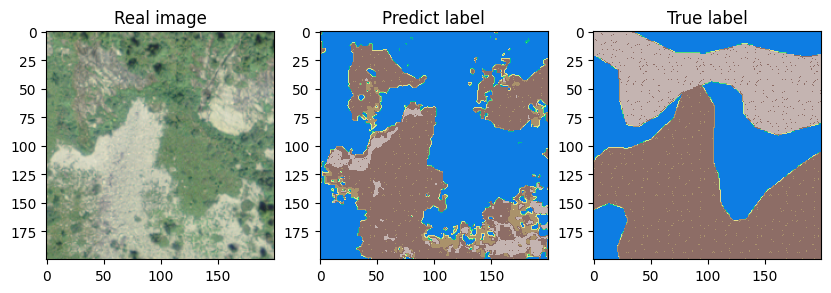

In [41]:
import matplotlib
plt.figure(figsize=(10, 10))
bounds = np.linspace(0, 8, 9)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

plt.subplot(1,3,1,title="Real image")
plt.imshow(unnormalize(data[0]).permute(1,2,0).cpu().detach().numpy())

plt.subplot(1,3,2,title="Predict label")
plt.imshow(np.reshape(predictions,(200,200)), norm=norm, cmap='terrain')

plt.subplot(1,3,3,title="True label")
plt.imshow(np.reshape(ground_truth,(200,200)), norm=norm, cmap='terrain')


In [41]:
len(test_pred)

460

In [42]:
a = np.reshape(ground_truth,(200,200))
b = np.reshape(predictions,(200,200))

In [47]:
a[100,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [48]:
b[100,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [109]:
bounds = np.linspace(0, 8, 9)
bounds

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])